In [21]:
# from google.colab import drive
# drive.mount("/content/gdrive")J

In [147]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.preprocessing import MinMaxScaler, StandardScaler, PowerTransformer

import warnings
warnings.filterwarnings('ignore')

from scipy import stats
%matplotlib inline
plt.rcParams['figure.figsize'] = [15, 10]

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential, layers, callbacks
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional

# Multivariate Time Series Forecasting

Next, I'll tackle the multivariate response problem. This should be straightforward.

But first I have to add in the other counties' data.

In [226]:
dat = pd.read_csv("Data/aqi_sample_data_wakulla_miami-dade_hillsborough_florida_bdate_20150101_edate_20191231_wind_speed_dir.csv")
dat.head(10)

,datetime_gmt,Wind_Speed_wakulla,Barometric_Pressure_wakulla,cos_Wind_Dir_wakulla,sin_Wind_Dir_wakulla,Wind_Speed_hillsborough,cos_Wind_Dir_hillsborough,sin_Wind_Dir_hillsborough,Wind_Speed_miami,cos_Wind_Dir_miami,sin_Wind_Dir_miami
0,8/12/2015 5:00,0.3,1008.0,0.987688,-0.156434,NaN,NaN,NaN,1.6,0.956305,0.292372
1,8/12/2015 6:00,0.1,1008.0,-0.927184,-0.374607,NaN,NaN,NaN,1.4,0.951057,0.309017
2,8/12/2015 7:00,0.1,1008.0,0.788011,-0.615661,NaN,NaN,NaN,1.4,0.615661,0.788011
3,8/12/2015 8:00,0.3,1008.0,-0.406737,-0.913545,NaN,NaN,NaN,1.7,0.891007,0.453991
4,8/12/2015 9:00,0.3,NaN,-0.484810,-0.874620,NaN,NaN,NaN,2.1,0.798636,0.601815
5,8/12/2015 10:00,0.3,NaN,-0.500000,-0.866025,NaN,NaN,NaN,0.6,0.987688,0.156434
6,8/12/2015 11:00,0.3,NaN,0.309017,0.951057,NaN,NaN,NaN,2.5,0.951057,0.309017
7,8/12/2015 12:00,0.7,NaN,0.529919,0.848048,NaN,NaN,NaN,2.1,0.743145,0.669131
8,8/12/2015 13:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.6,-0.104528,0.994522
9,8/12/2015 14:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.8,-0.961262,0.275637


In [227]:
from pandas._config import dates

def make_datetime_index(dat):
    dat_prep = dat.copy()
    dat_prep["datetime_gmt"] = pd.to_datetime(dat_prep["datetime_gmt"])
    dat_prep = dat_prep.set_index("datetime_gmt")
    return dat_prep
    
dat = make_datetime_index(dat)
dat.head(5)

,Wind_Speed_wakulla,Barometric_Pressure_wakulla,cos_Wind_Dir_wakulla,sin_Wind_Dir_wakulla,Wind_Speed_hillsborough,cos_Wind_Dir_hillsborough,sin_Wind_Dir_hillsborough,Wind_Speed_miami,cos_Wind_Dir_miami,sin_Wind_Dir_miami
datetime_gmt,,,,,,,,,,
2015-08-12 05:00:00,0.3,1008.0,0.987688,-0.156434,NaN,NaN,NaN,1.6,0.956305,0.292372
2015-08-12 06:00:00,0.1,1008.0,-0.927184,-0.374607,NaN,NaN,NaN,1.4,0.951057,0.309017
2015-08-12 07:00:00,0.1,1008.0,0.788011,-0.615661,NaN,NaN,NaN,1.4,0.615661,0.788011
2015-08-12 08:00:00,0.3,1008.0,-0.406737,-0.913545,NaN,NaN,NaN,1.7,0.891007,0.453991
2015-08-12 09:00:00,0.3,NaN,-0.484810,-0.874620,NaN,NaN,NaN,2.1,0.798636,0.601815


<AxesSubplot:xlabel='datetime_gmt'>

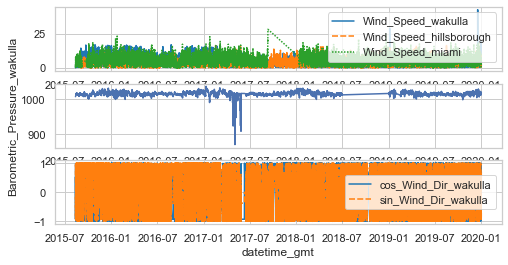

In [228]:
sns.set_theme(style = "whitegrid")

wind_speed_cols = ["Wind_Speed_wakulla", "Wind_Speed_hillsborough", "Wind_Speed_miami"]
fig, axs = plt.subplots(nrows = 3)
sns.lineplot(data = dat[wind_speed_cols], palette = "tab10", ax = axs[0])
sns.lineplot(data = dat[ "Barometric_Pressure_wakulla"], palette = "tab10", ax = axs[1])
sns.lineplot(data = dat[["cos_Wind_Dir_wakulla", "sin_Wind_Dir_wakulla"]], palette = "tab10", ax = axs[2])

<AxesSubplot:>

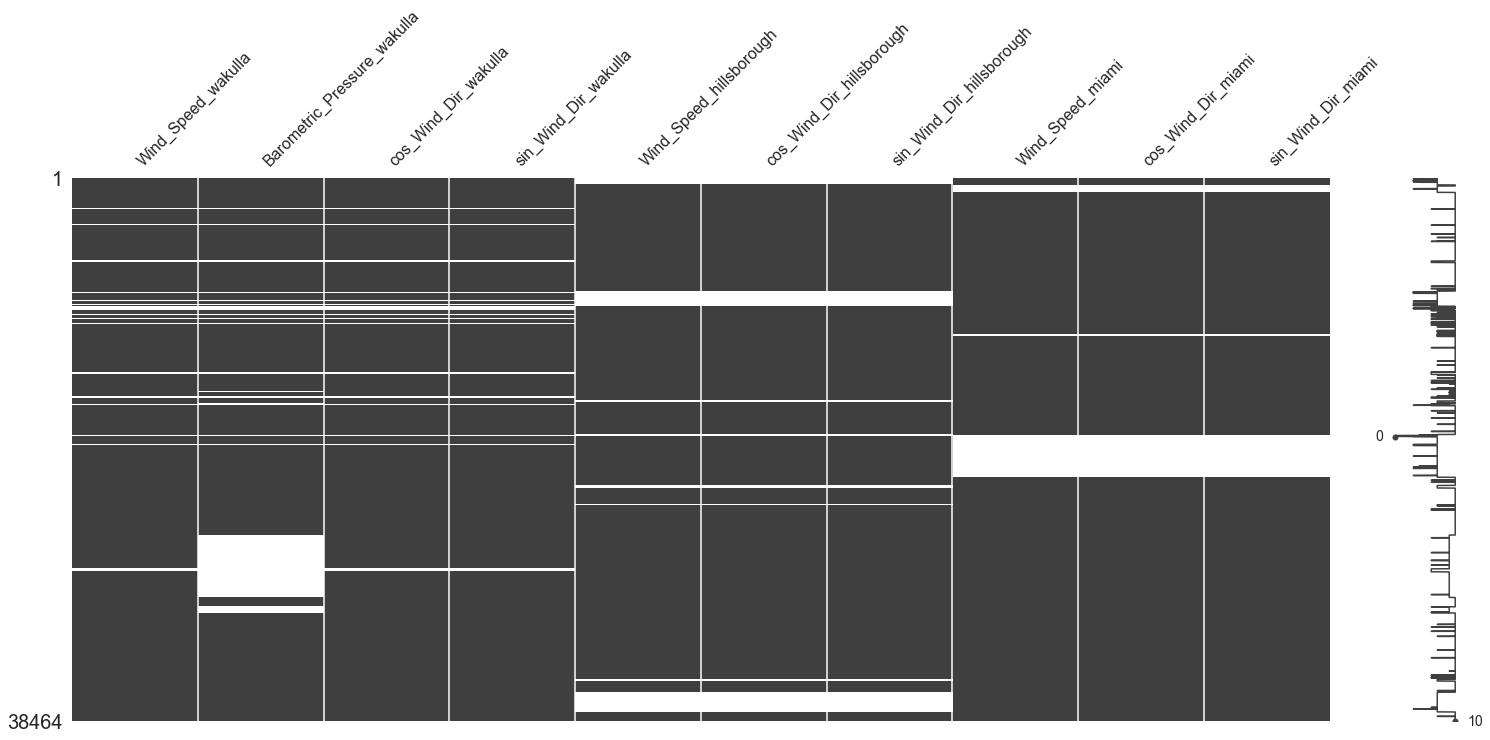

In [236]:
import missingno as msno

plt.rcParams['figure.figsize'] = [6,4]

msno.matrix(dat)

In [230]:
miss_mat = dat.isna().replace([True, False], [1, 0])
miss_mat.sum(axis = 0)

Wind_Speed_wakulla             1753
Barometric_Pressure_wakulla    6403
cos_Wind_Dir_wakulla           1753
sin_Wind_Dir_wakulla           1753
Wind_Speed_hillsborough        3610
cos_Wind_Dir_hillsborough      3610
sin_Wind_Dir_hillsborough      3610
Wind_Speed_miami               3726
cos_Wind_Dir_miami             3726
sin_Wind_Dir_miami             3726
dtype: int64

<AxesSubplot:>

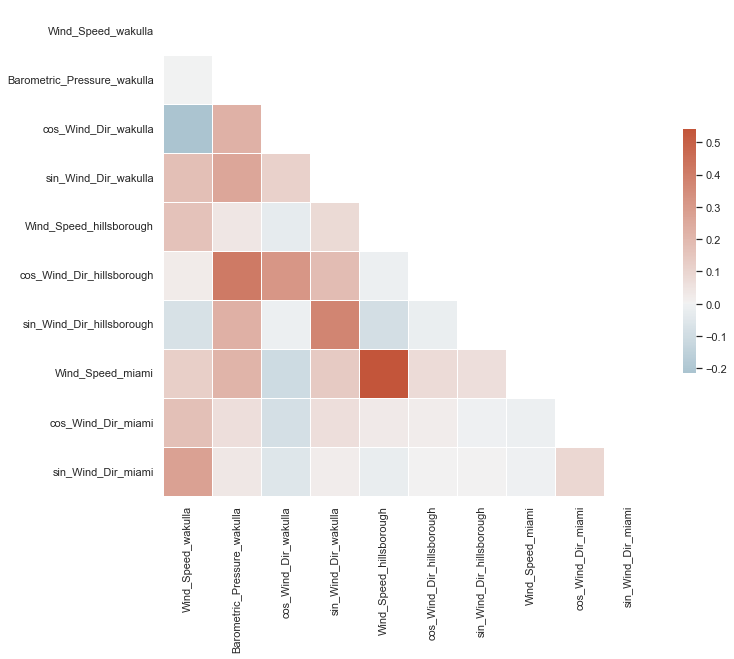

In [231]:
corr = dat.corr()

mask = np.triu(np.ones_like(corr, dtype=bool))

f, ax = plt.subplots(figsize = (11,9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, center = 0, square=True, 
            linewidths=.5, cbar_kws={"shrink": .5})

Train and Test split. I'll use 70% and 30%. I'll use the imputation methods from Che et al (2018). Namely filling all of the missing values with the mean from the training data set in the train and test data sets.

In [9]:
n_train = int(len(dat) * 0.7)

train_means = dat.iloc[1:n_train, :].mean()
train_means

Wind_Speed_wakulla                4.351169
Barometric_Pressure_wakulla    1016.409353
cos_Wind_Dir_wakulla              0.018055
sin_Wind_Dir_wakulla              0.068549
Wind_Speed_hillsborough           3.931373
cos_Wind_Dir_hillsborough         0.114337
sin_Wind_Dir_hillsborough         0.231935
Wind_Speed_miami                  5.636167
cos_Wind_Dir_miami                0.096620
sin_Wind_Dir_miami                0.191819
dtype: float64

In [10]:
dat.fillna(value = train_means, inplace = True)
dat = dat.dropna()
print(dat.shape)
dat.head(5)

(38464, 10)


,Wind_Speed_wakulla,Barometric_Pressure_wakulla,cos_Wind_Dir_wakulla,sin_Wind_Dir_wakulla,Wind_Speed_hillsborough,cos_Wind_Dir_hillsborough,sin_Wind_Dir_hillsborough,Wind_Speed_miami,cos_Wind_Dir_miami,sin_Wind_Dir_miami
datetime_gmt,,,,,,,,,,
2015-08-12 05:00:00,0.3,1008.000000,0.987688,-0.156434,3.931373,0.114337,0.231935,1.6,0.956305,0.292372
2015-08-12 06:00:00,0.1,1008.000000,-0.927184,-0.374607,3.931373,0.114337,0.231935,1.4,0.951057,0.309017
2015-08-12 07:00:00,0.1,1008.000000,0.788011,-0.615661,3.931373,0.114337,0.231935,1.4,0.615661,0.788011
2015-08-12 08:00:00,0.3,1008.000000,-0.406737,-0.913545,3.931373,0.114337,0.231935,1.7,0.891007,0.453991
2015-08-12 09:00:00,0.3,1016.409353,-0.484810,-0.874620,3.931373,0.114337,0.231935,2.1,0.798636,0.601815


In [11]:
train_dat = dat.iloc[:n_train]
test_dat = dat.iloc[n_train:]

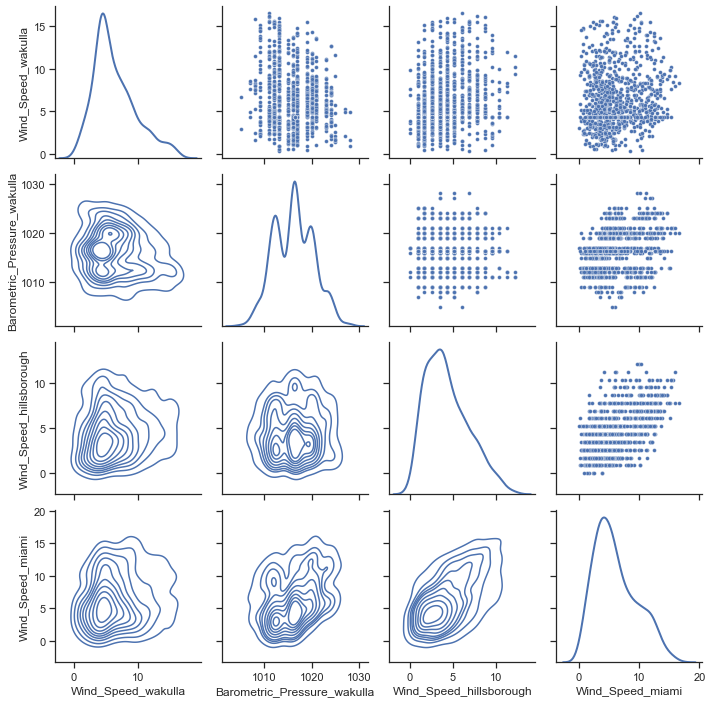

In [12]:
sns.set_theme(style = "ticks")

g = sns.PairGrid(train_dat.iloc[5000:6000,[0,1,4,7]], diag_sharey=False)
g.map_upper(sns.scatterplot, s = 15)
g.map_diag(sns.kdeplot, lw = 2)
g.map_lower(sns.kdeplot)

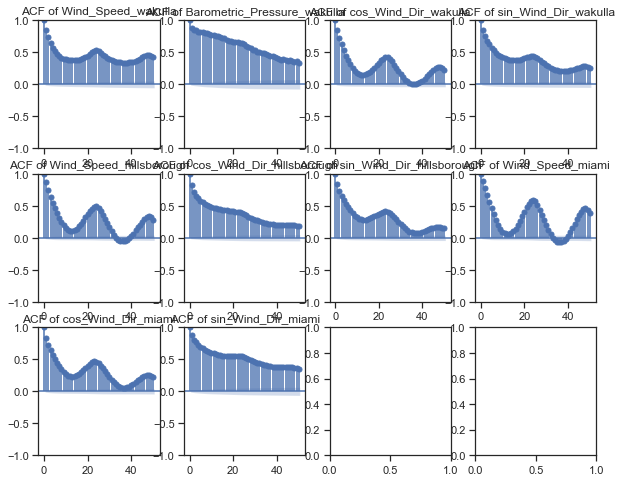

In [13]:
import statsmodels.api as sm
fig, axs = plt.subplots(nrows = 3, ncols = 4)

for i in [0,1,2]:
    for j in [0,1,2,3]:
        col_ind = j + 4 * i
        if col_ind >= 10:
            break
        sm.graphics.tsa.plot_acf(train_dat.iloc[:, col_ind].values.squeeze(), lags = 50, ax = axs[i,j], title = "ACF of " + train_dat.columns[col_ind])
    if col_ind >= 10:
        break

Transformation pre-processing. I'll use the MinMaxScaler() for now. I'll try detrending later.

In [14]:
# scaler_speed = MinMaxScaler().fit(train_dat[wind_speed_cols])
# scaler_press = MinMaxScaler().fit(train_dat[['Barometric_Pressure_wakulla']])
scaler_speed = StandardScaler().fit(train_dat[wind_speed_cols])
scaler_press = StandardScaler().fit(train_dat[['Barometric_Pressure_wakulla']])
# scaler_speed = PowerTransformer(method = "box-cox").fit(train_dat[wind_speed_cols] + 1)
# scaler_press = PowerTransformer(method = "box-cox").fit(train_dat[['Barometric_Pressure_wakulla']])

train_dat[wind_speed_cols] = scaler_speed.transform(train_dat[wind_speed_cols] + 1)
test_dat[wind_speed_cols] = scaler_speed.transform(test_dat[wind_speed_cols] + 1)

train_dat[['Barometric_Pressure_wakulla']] = scaler_press.transform(train_dat[['Barometric_Pressure_wakulla']])
test_dat[['Barometric_Pressure_wakulla']] = scaler_press.transform(test_dat[['Barometric_Pressure_wakulla']])

train_dat.head(5)

,Wind_Speed_wakulla,Barometric_Pressure_wakulla,cos_Wind_Dir_wakulla,sin_Wind_Dir_wakulla,Wind_Speed_hillsborough,cos_Wind_Dir_hillsborough,sin_Wind_Dir_hillsborough,Wind_Speed_miami,cos_Wind_Dir_miami,sin_Wind_Dir_miami
datetime_gmt,,,,,,,,,,
2015-08-12 05:00:00,-1.097131,-1.649448,0.987688,-0.156434,0.431808,0.114337,0.231935,-0.953555,0.956305,0.292372
2015-08-12 06:00:00,-1.169050,-1.649448,-0.927184,-0.374607,0.431808,0.114337,0.231935,-1.016372,0.951057,0.309017
2015-08-12 07:00:00,-1.169050,-1.649448,0.788011,-0.615661,0.431808,0.114337,0.231935,-1.016372,0.615661,0.788011
2015-08-12 08:00:00,-1.097131,-1.649448,-0.406737,-0.913545,0.431808,0.114337,0.231935,-0.922147,0.891007,0.453991
2015-08-12 09:00:00,-1.097131,0.000061,-0.484810,-0.874620,0.431808,0.114337,0.231935,-0.796515,0.798636,0.601815


<AxesSubplot:xlabel='datetime_gmt'>

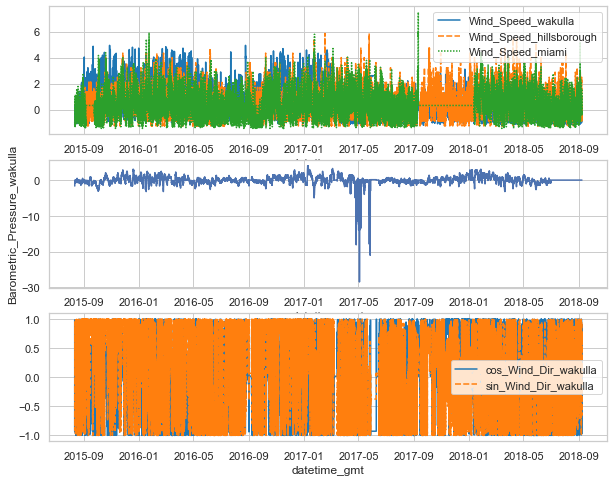

In [15]:
sns.set_theme(style = "whitegrid")

wind_speed_cols = ["Wind_Speed_wakulla", "Wind_Speed_hillsborough", "Wind_Speed_miami"]
fig, axs = plt.subplots(nrows = 3)
sns.lineplot(data = train_dat[wind_speed_cols], palette = "tab10", ax = axs[0])
sns.lineplot(data = train_dat[ "Barometric_Pressure_wakulla"], palette = "tab10", ax = axs[1])
sns.lineplot(data = train_dat[["cos_Wind_Dir_wakulla", "sin_Wind_Dir_wakulla"]], palette = "tab10",
             ax = axs[2])

Input data.

The inputs are the previous time points of the output variable and the previous time points of the other variables.

In [16]:
def create_dataset(dat, lags = 1):
  """ GRU takes a 3D array so the data must be re-shaped to:
  - [N, T, P]
  - N = number of samples
  - T = number of time steps
  - P = number of predictors
  """
  Inputs, Outputs = [], []
  X = dat.to_numpy()

  for i in range(len(X) - lags):
    v = X[i:i+lags]
    Inputs.append(v)
    Outputs.append(X[i + lags])

  return np.array(Inputs), np.array(Outputs)

lags = 96

X_train, y_train = create_dataset(train_dat, lags)
X_test, y_test = create_dataset(test_dat, lags)

print('X_train.shape: ', X_train.shape)
print('y_train.shape: ', y_train.shape)
print('X_test.shape: ', X_test.shape) 
print('y_test.shape: ', y_test.shape)

X_train.shape:  (26828, 96, 10)
y_train.shape:  (26828, 10)
X_test.shape:  (11444, 96, 10)
y_test.shape:  (11444, 10)


In [17]:
y_train

array([[-1.62183994e-01, -8.02339862e-02,  2.92371705e-01, ...,
         2.00957875e-02,  8.57167301e-01,  5.15038075e-01],
       [-5.57738613e-01, -8.02339862e-02,  2.07911691e-01, ...,
        -1.05536624e-01,  7.07106781e-01,  7.07106781e-01],
       [-7.73495677e-01, -8.02339862e-02, -1.21869343e-01, ...,
        -1.05536624e-01,  8.48048096e-01,  5.29919264e-01],
       ...,
       [-8.09455188e-01,  6.12653753e-05,  7.07106781e-01, ...,
        -2.31169036e-01, -5.15038075e-01, -8.57167301e-01],
       [-6.29657634e-01,  6.12653753e-05,  7.54709580e-01, ...,
        -2.31169036e-01, -6.81998360e-01, -7.31353702e-01],
       [-4.49860080e-01,  6.12653753e-05,  6.15661475e-01, ...,
        -2.93985242e-01, -6.29320391e-01, -7.77145961e-01]])

In [91]:
def fit_mvt_model(model, checkpoint_path, batch_size = 32):
    checkpoint_dir = os.path.dirname(checkpoint_path)

    early_stop = keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 25)

    cp_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_path,
        save_weights_only = True, 
        verbose = 1)

    history = model.fit(X_train, y_train, epochs = 100,  
                        validation_split = 0.2,
                        batch_size = batch_size,
                        shuffle = False, 
                        callbacks = [early_stop, cp_callback])
    return history

# make and plot test forecasts with the Gaussian GRU model.
def plot_loss (history, model_name):
    plt.figure(figsize = (10, 6))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Train vs Validation Loss for ' + model_name)
    plt.ylabel('Loss')
    plt.xlabel('epoch')
    plt.legend(['Train loss', 'Validation loss'], loc='upper right')

def plot_future(prediction, model_name, y_test, ylab):
    plt.figure(figsize=(10, 6))
    range_future = len(prediction)
    plt.plot(np.arange(range_future), np.array(y_test), 
             label='Test data')
    plt.plot(np.arange(range_future), 
             np.array(prediction),label='Prediction')    
    plt.title('Test data vs prediction for ' + model_name)
    plt.legend(loc='upper left')
    plt.xlabel('Time (day)')
    plt.ylabel(ylab)

def make_predictions(X_test, y_test, model, scaler, model_name, ylab):
    prediction = model.predict(X_test)
    pred = np.append(prediction, prediction, 1)
    pred = scaler.inverse_transform(pred)
    pred_gru = pred[:,0]

    plot_future(pred_gru, model_name, y_test, ylab)

    return prediction, pred_gru

## GEVL Functions

$$L_{GEVL}(X^1, Y) = -\frac{1}{T \tau} \sum_{t = 1}^T \log \mathcal{K}\left(\frac{f_\theta (X^1_{1:t}) - \phi(y_t)}{\tau}\right)$$
where $Y = {y_1,..., y_{T-1}}$ with $y_t = x_{t+1}$, $\mathcal{K}$ is a kernel density estimate with bandwidth $\tau$, $f_\theta$ is our model output indexed by $\theta$, and $\phi(t_t)$ is a transformation function.

- Gaussian: $\mathcal{K}(x) = \tau^{-1}\exp\left[-\frac{(x - \mu)^2}{\tau}\right]$
- Gumbel: $\mathcal{K}(x) = \exp\left[-(z + e^{-z})\right]$ where $z = \frac{x - \mu}{\beta}$
- Fr\'{e}chet: $\mathcal{K}(x) = \frac{\alpha}{s}\left(z\right)^{-1-\alpha}\exp\left[-z^{-\alpha}\right]$ where $z = \frac{x + s(\alpha/(1 + \alpha))^{1/\alpha}}{s}$ for $x > 0$
- Gamma: $\mathcal{K}(x) = x^{\alpha-1} e^{-x/\beta}$, where $x > 0$
- Cauchy: $\mathcal{K}(x) = (1 + \frac{x - m}{\gamma})^{-2}$, where $x \in \mathbb{R}$
- Pareto: $\mathcal{K}(x) = \frac{s^\alpha}{x^{\alpha+1}}$, where $x > s$

Here's the corresponding GEVL functions:

- Gaussian: $L_{Gaussian}(X^k, Y) = \frac{1}{T} \sum_{t=1}^T \delta^2 = L_{SquaredError}(X^k, Y)$
- Gumbel: $L_{Gumbel}(X^k, Y) = \frac{1}{T} \sum_{t=1}^T \delta^2 \left[1 - \exp\left(-\delta^2\right)\right]^\gamma$
- Fr\'echet: $L_{Fr\acute{e}chet}(X^k, Y) = \frac{\alpha+1}{T} \sum_{t=1}^T \log z + \frac{1}{T} \sum_{t=1}^T z^{-\alpha}$
- Cauchy: $L_{Cauchy}(X^k, Y) = \frac{2}{T} \sum_{t=1}^T \log \left[1 + \delta \right]$
- Pareto: $L_{Pareto}(X^k, Y) = \frac{\alpha + 1}{T} \sum_{t=1}^T \log\delta$

I'm going to implement the Gumbel one here. Others will be in a separate notebook.

In [240]:
# Gaussian
def Gaussian_GEVL_fn():
  def gevl_Gaussian(y_true, y_pred):
    delta = y_pred - y_true
    gevl = tf.square(-delta)
    return tf.reduce_mean(gevl, axis = -1)
  return gevl_Gaussian

# Gumbel GEVL
def gumbel_GEVL_fn(gamma):
  def gevl_gumbel(y_true, y_pred):
    delta = y_pred - y_true
    gevl = tf.multiply(tf.pow(1 - tf.exp(-tf.square(delta)), gamma), tf.square(delta))
    return tf.reduce_mean(gevl, axis = -1)
  return gevl_gumbel

# Frechet GEVL
def Frechet_GEVL_fn(alpha,s):
  def gevl_Frechet(y_true, y_pred):
    delta = tf.nn.relu(y_pred - y_true)
    Zeta = tf.divide(delta,s) + tf.pow( tf.divide(alpha,(1.0 + alpha)),
                            tf.divide(1.0, alpha))
    # gevl1 = tf.multiply(alpha + 1.0, tf.math.log(Zeta))
    # gevl2 = tf.pow(Zeta, -alpha)
    gevl1 = tf.multiply(-1.0 - alpha, -tf.pow(Zeta, -alpha))
    gevl2 = tf.math.log(Zeta)
    gevl = tf.add(gevl1, gevl2)
    return tf.reduce_mean(gevl, axis = -1)
  return gevl_Frechet

# Cauchy
def Cauchy_GEVL_fn(tau):
  def gevl_Cauchy(y_true, y_pred):
    delta = y_pred - y_true
    gevl = tf.math.log(1.0 + tf.pow(delta / tau, 2.0))
    return tf.reduce_mean(gevl, axis = -1)
  return gevl_Cauchy

# Pareto
def Pareto_GEVL_fn(alpha,s):
  def gevl_Pareto(y_true, y_pred):
    delta = tf.nn.relu(y_pred - y_true)
    gevl = tf.multiply(alpha + 1.0, tf.math.log(delta))
    return tf.reduce_mean(gevl, axis = -1)
  return gevl_Pareto

https://www.tensorflow.org/tutorials/keras/save_and_load#setup

Epoch 1/100
670/671 [============================>.] - ETA: 0s - loss: 0.2811
Epoch 1: saving model to gaussian_training\cp.ckpt
671/671 [==============================] - 26s 36ms/step - loss: 0.2812 - val_loss: 0.1993
Epoch 2/100
670/671 [============================>.] - ETA: 0s - loss: 0.2130
Epoch 2: saving model to gaussian_training\cp.ckpt
671/671 [==============================] - 29s 43ms/step - loss: 0.2131 - val_loss: 0.1757
Epoch 3/100
670/671 [============================>.] - ETA: 0s - loss: 0.2027
Epoch 3: saving model to gaussian_training\cp.ckpt
671/671 [==============================] - 26s 39ms/step - loss: 0.2028 - val_loss: 0.1667
Epoch 4/100
671/671 [==============================] - ETA: 0s - loss: 0.1989
Epoch 4: saving model to gaussian_training\cp.ckpt
671/671 [==============================] - 24s 35ms/step - loss: 0.1989 - val_loss: 0.1635
Epoch 5/100
671/671 [==============================] - ETA: 0s - loss: 0.1962
Epoch 5: saving model to gaussian_training

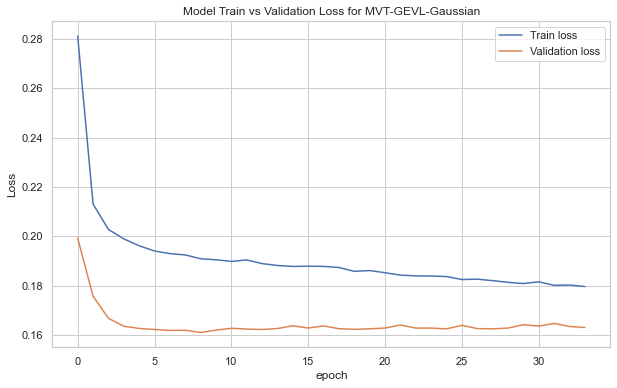

In [92]:
def create_GRU_mvt(units):
  model = Sequential()

  # Input Layer
  model.add(GRU(units = units, return_sequences=True,
            input_shape = (X_train.shape[1], X_train.shape[2])))
  model.add(Dropout(0.2))

  # Hidden Layer
  model.add(GRU(units = 32))
  model.add(Dropout(0.2))
  model.add(Dense(units = 10))

  # Compile Model
  model.compile(optimizer = 'adam', loss = 'mse')

  return model

model_GRU_mvt = create_GRU_mvt(64) 
history_gru_mvt = fit_mvt_model(model_GRU_mvt, checkpoint_path="gaussian_training/cp.ckpt")
history_gru_mvt.model.save("saved_model/gaussian_gru")

plot_loss(history_gru_mvt, 'MVT-GEVL-Gaussian')

In [93]:
history_gru_mvt.model.summary()
# !mkdir -p saved_model


Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_28 (GRU)                (None, 96, 64)            14592     
                                                                 
 dropout_28 (Dropout)        (None, 96, 64)            0         
                                                                 
 gru_29 (GRU)                (None, 32)                9408      
                                                                 
 dropout_29 (Dropout)        (None, 32)                0         
                                                                 
 dense_14 (Dense)            (None, 10)                330       
                                                                 
Total params: 24,330
Trainable params: 24,330
Non-trainable params: 0
_________________________________________________________________


INFO:tensorflow:Assets written to: saved_model/gaussian_gru\assets


INFO:tensorflow:Assets written to: saved_model/gaussian_gru\assets


Epoch 1/100
670/671 [============================>.] - ETA: 0s - loss: 0.1602
Epoch 1: saving model to gumbel_training\cp.ckpt
671/671 [==============================] - 29s 39ms/step - loss: 0.1602 - val_loss: 0.0906
Epoch 2/100
671/671 [==============================] - ETA: 0s - loss: 0.1111
Epoch 2: saving model to gumbel_training\cp.ckpt
671/671 [==============================] - 26s 39ms/step - loss: 0.1111 - val_loss: 0.0802
Epoch 3/100
670/671 [============================>.] - ETA: 0s - loss: 0.1045
Epoch 3: saving model to gumbel_training\cp.ckpt
671/671 [==============================] - 26s 39ms/step - loss: 0.1045 - val_loss: 0.0772
Epoch 4/100
670/671 [============================>.] - ETA: 0s - loss: 0.1011
Epoch 4: saving model to gumbel_training\cp.ckpt
671/671 [==============================] - 25s 38ms/step - loss: 0.1012 - val_loss: 0.0749
Epoch 5/100
670/671 [============================>.] - ETA: 0s - loss: 0.0990
Epoch 5: saving model to gumbel_training\cp.ckpt
6

INFO:tensorflow:Assets written to: saved_model/gumbel_gru\assets


INFO:tensorflow:Assets written to: saved_model/gumbel_gru\assets


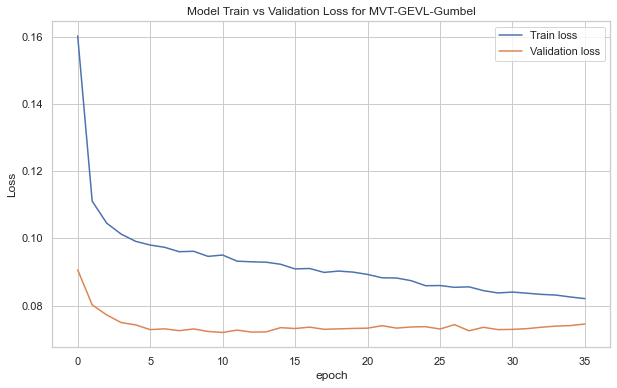

In [94]:
def create_GRU_Gumbel_mvt(units):
  model = Sequential()

  # Input Layer
  model.add(GRU(units = units, return_sequences=True,
            input_shape = (X_train.shape[1], X_train.shape[2])))
  model.add(Dropout(0.2))

  # Hidden Layer
  model.add(GRU(units = 32))
  model.add(Dropout(0.2))
  model.add(Dense(units = 10))

  # Compile Model
  model.compile(optimizer = 'adam', loss = gumbel_GEVL_fn(gamma = 1.1))

  return model

model_gumbel_mvt = create_GRU_Gumbel_mvt(64) 
history_gumbel_mvt = fit_mvt_model(model_gumbel_mvt, checkpoint_path="gumbel_training/cp.ckpt")
history_gumbel_mvt.model.save("saved_model/gumbel_gru")

plot_loss(history_gumbel_mvt, 'MVT-GEVL-Gumbel')

Epoch 1/100
671/671 [==============================] - ETA: 0s - loss: 0.1856
Epoch 1: saving model to cauchy_training\cp.ckpt
671/671 [==============================] - 29s 40ms/step - loss: 0.1856 - val_loss: 0.1401
Epoch 2/100
670/671 [============================>.] - ETA: 0s - loss: 0.1424
Epoch 2: saving model to cauchy_training\cp.ckpt
671/671 [==============================] - 31s 46ms/step - loss: 0.1425 - val_loss: 0.1265
Epoch 3/100
670/671 [============================>.] - ETA: 0s - loss: 0.1357
Epoch 3: saving model to cauchy_training\cp.ckpt
671/671 [==============================] - 32s 48ms/step - loss: 0.1358 - val_loss: 0.1222
Epoch 4/100
670/671 [============================>.] - ETA: 0s - loss: 0.1332
Epoch 4: saving model to cauchy_training\cp.ckpt
671/671 [==============================] - 31s 47ms/step - loss: 0.1332 - val_loss: 0.1202
Epoch 5/100
671/671 [==============================] - ETA: 0s - loss: 0.1325
Epoch 5: saving model to cauchy_training\cp.ckpt
6

INFO:tensorflow:Assets written to: saved_model/cauchy_gru\assets


INFO:tensorflow:Assets written to: saved_model/cauchy_gru\assets


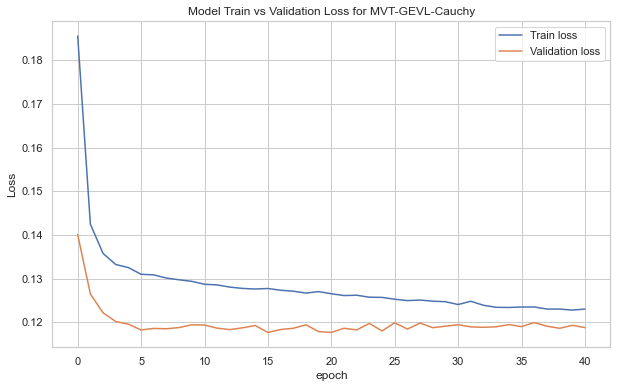

In [128]:
def create_GRU_Cauchy_mvt(units):
  model = Sequential()

  # Input Layer
  model.add(GRU(units = units, return_sequences=True,
            input_shape = (X_train.shape[1], X_train.shape[2])))
  model.add(Dropout(0.2))

  # Hidden Layer
  model.add(GRU(units = 32))
  model.add(Dropout(0.2))
  model.add(Dense(units = 10))

  # Compile Model
  model.compile(optimizer = 'adam', loss = Cauchy_GEVL_fn(tau = 1))

  return model

model_cauchy_mvt = create_GRU_Cauchy_mvt(64) 
history_cauchy_mvt = fit_mvt_model(model_cauchy_mvt, checkpoint_path="cauchy_training/cp.ckpt")
history_cauchy_mvt.model.save("saved_model/cauchy_gru")

plot_loss(history_cauchy_mvt, 'MVT-GEVL-Cauchy')

Epoch 1/100
670/671 [============================>.] - ETA: 0s - loss: 1.4456
Epoch 1: saving model to frechet_training\cp.ckpt
671/671 [==============================] - 34s 46ms/step - loss: 1.4456 - val_loss: 1.3064
Epoch 2/100
671/671 [==============================] - ETA: 0s - loss: 0.8851
Epoch 2: saving model to frechet_training\cp.ckpt
671/671 [==============================] - 32s 47ms/step - loss: 0.8851 - val_loss: 1.6343
Epoch 3/100
670/671 [============================>.] - ETA: 0s - loss: 0.8100
Epoch 3: saving model to frechet_training\cp.ckpt
671/671 [==============================] - 31s 47ms/step - loss: 0.8103 - val_loss: 0.9355
Epoch 4/100
671/671 [==============================] - ETA: 0s - loss: 0.7683
Epoch 4: saving model to frechet_training\cp.ckpt
671/671 [==============================] - 36s 53ms/step - loss: 0.7683 - val_loss: 0.7613
Epoch 5/100
671/671 [==============================] - ETA: 0s - loss: 0.7471
Epoch 5: saving model to frechet_training\cp.c

INFO:tensorflow:Assets written to: saved_model/frechet_gru\assets


INFO:tensorflow:Assets written to: saved_model/frechet_gru\assets


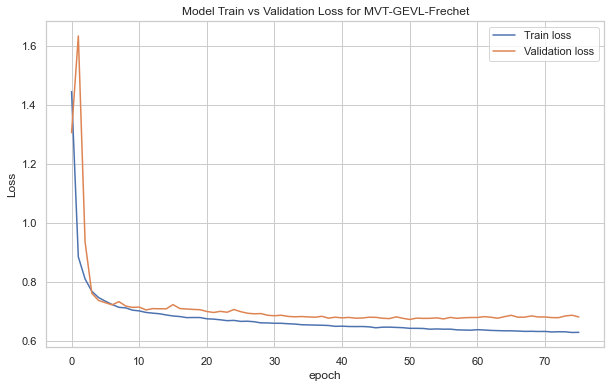

In [129]:
def create_GRU_Frechet_GEVL_mvt(units):
  model = Sequential()

  # Input Layer
  model.add(GRU(units = units, return_sequences=True,
            input_shape = (X_train.shape[1], X_train.shape[2])))
  model.add(Dropout(0.2))

  # Hidden Layer
  model.add(GRU(units = 32))
  model.add(Dropout(0.2))
  model.add(Dense(units = 10))

  # Compile Model
  model.compile(optimizer = 'adam', loss = Frechet_GEVL_fn(alpha = 13.0, s = 1.7))

  return model

model_frechet_mvt = create_GRU_Frechet_GEVL_mvt(64)
history_frechet = fit_mvt_model(model_frechet_mvt, checkpoint_path="frechet_training/cp.ckpt")
history_frechet.model.save("saved_model/frechet_gru")

plot_loss(history_frechet, 'MVT-GEVL-Frechet')

In [241]:
def create_GRU_Pareto_GEVL_mvt(units):
  model = Sequential()

  # Input Layer
  model.add(GRU(units = units, return_sequences=True,
            input_shape = (X_train.shape[1], X_train.shape[2])))
  model.add(Dropout(0.2))

  # Hidden Layer
  model.add(GRU(units = 32))
  model.add(Dropout(0.2))
  model.add(Dense(units = 10))

  # Compile Model
  model.compile(optimizer = 'adam', loss = Pareto_GEVL_fn(alpha = 1, s = 2))

  return model

model_pareto_mvt = create_GRU_Pareto_GEVL_mvt(64)
history_pareto = fit_mvt_model(model_pareto_mvt, checkpoint_path="pareto_training/cp.ckpt")
history_pareto.model.save("saved_model/pareto_gru")

plot_loss(history_pareto, 'MVT-GEVL-Pareto')

Epoch 1/100
149/671 [=====>........................] - ETA: 23s - loss: nan

KeyboardInterrupt: 

## Forecasting with the Multivariate GRU Models

Next I'll forecast with the GRU models on the test data set. I'll evaluate with the RMSE and M(edian)AE by TS. 

In [133]:
def mvt_forecast(model, X_test):
    prediction_mvt = model.predict(X_test)
    pred_mvt = prediction_mvt

    pred_mvt[:,[0,4,7]] = scaler_speed.inverse_transform(pred_mvt[:,[0,4,7]])
    pred_mvt[:,1] = scaler_press.inverse_transform(pred_mvt[:,1].reshape(-1,1))[:,0]
    return prediction_mvt, pred_mvt

In [134]:
prediction_mvt, pred_mvt = mvt_forecast(model_GRU_mvt, X_test)

358/358 [==============================] - 5s 13ms/step


In [135]:
y_test_2 = y_test
y_test_2[:,[0,4,7]] = y_test_speed
y_test_2[:,1] = y_test_press[:,0]
y_test_2

array([[ 2.60000000e+00,  1.01640935e+03,  9.51056516e-01, ...,
         4.70000000e+00, -9.45518576e-01, -3.25568154e-01],
       [ 2.20000000e+00,  1.01640935e+03,  9.99390827e-01, ...,
         5.30000000e+00, -8.09016994e-01, -5.87785252e-01],
       [ 2.60000000e+00,  1.01640935e+03,  7.19339800e-01, ...,
         4.90000000e+00, -7.54709580e-01, -6.56059029e-01],
       ...,
       [ 3.10000000e+00,  1.01900000e+03,  6.01815023e-01, ...,
         3.50000000e+00, -8.19152044e-01, -5.73576436e-01],
       [ 2.60000000e+00,  1.02000000e+03,  5.73576436e-01, ...,
         4.50000000e+00, -9.61261696e-01, -2.75637356e-01],
       [ 3.00000000e+00,  1.02000000e+03,  7.07106781e-01, ...,
         5.90000000e+00, -9.81627183e-01, -1.90808995e-01]])

In [193]:
def plot_forecasts_mvt(prediction, model_name, y_test):

    def plot_future2(ax, prediction, model_name, y_test, ylab):
        range_future = len(prediction)
        ax.plot(np.arange(range_future), np.array(y_test), 
                label='Test data')
        ax.plot(np.arange(range_future), 
                np.array(prediction), label= 'Prediction')    
        ax.set_title(ylab)
        ax.legend(loc='upper left')
        ax.set_xlabel('Time (day)')
        ax.set_ylabel('')
        ax.set_xlim(1,1000)

    fig, ((ax1, ax2, ax3, ax4), 
        (ax5, ax6, ax7, ax8),
        (ax9, ax10, ax11, ax12)) = plt.subplots(nrows = 3, ncols = 4)
    fig.suptitle(model_name)

    plot_future2(ax1, prediction[:, 0], "", y_test[:,0], "Wind Speed - Wakulla")
    plot_future2(ax2, prediction[:, 2], "", y_test[:,2], "cos(Wind Angle Wakulla)")
    plot_future2(ax3, prediction[:, 3], "", y_test[:,3], "sin(Wind Angle Wakulla)")
    plot_future2(ax4, prediction[:, 1], "", y_test[:,1], "Pressure")
    plot_future2(ax5, prediction[:, 4], "", y_test[:,4], "Wind Speed - Hillsborough")
    plot_future2(ax6, prediction[:, 5], "", y_test[:,5], "cos(Wind Angle Hillsborough)")
    plot_future2(ax7, prediction[:, 6], "", y_test[:,6], "sin(Wind Angle Hillsborough)")
    plot_future2(ax9, prediction[:, 7], "", y_test[:,7], "Wind Speed - Miami-Dade")
    plot_future2(ax10, prediction[:, 8], "", y_test[:,8], "cos(Wind Angle Miami-Dade)")
    plot_future2(ax11, prediction[:, 9], "", y_test[:,9], "sin(Wind Angle Miami-Dade)")

    plt.tight_layout()
    plt.show()

from sklearn.metrics import mean_squared_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import mean_absolute_error

def evaluate_prediction(predictions, actual, model_name):
    mae = mean_squared_error(actual, predictions, multioutput="raw_values", squared=False)
    rmse = median_absolute_error(actual, predictions, multioutput="raw_values")

    res = pd.DataFrame({"Var": train_dat.columns,
                      model_name + "-MAE": mae, model_name + "-RMSE": rmse})
    print(res)
    return res

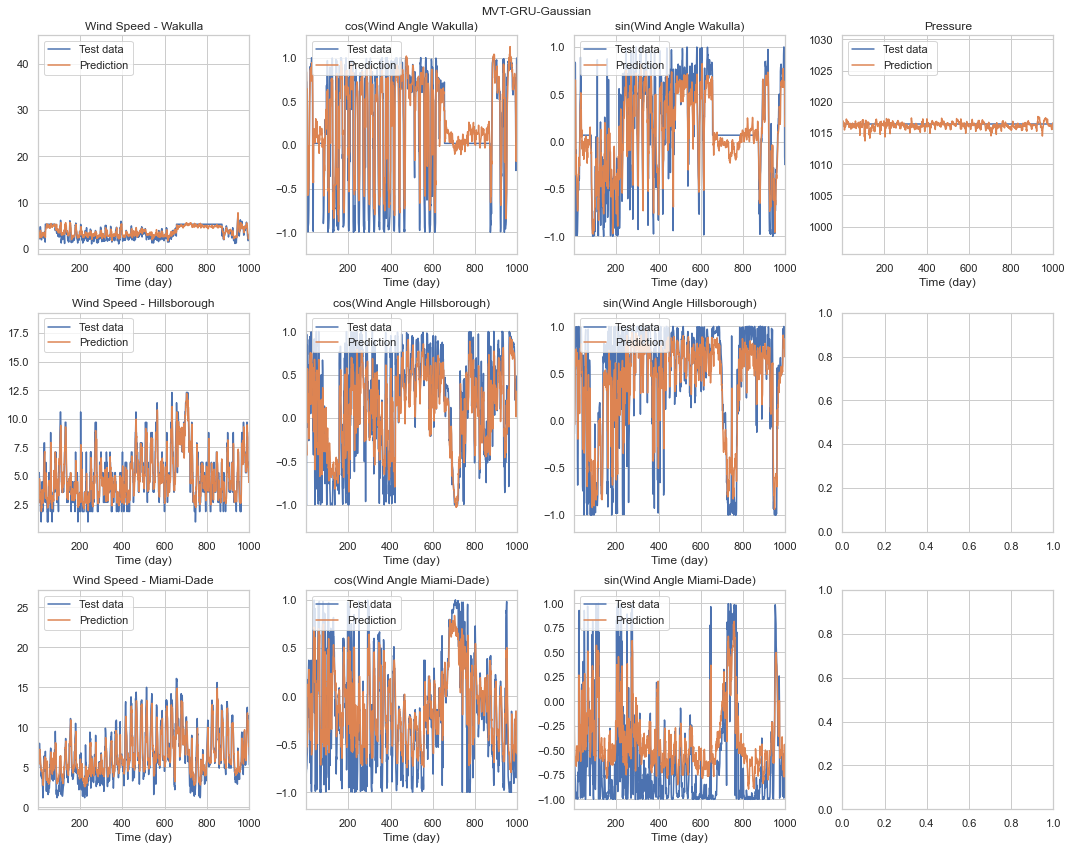

                           Var  MVT-GRU-Gaussian-MAE  MVT-GRU-Gaussian-RMSE
0           Wind_Speed_wakulla              1.026280               0.558956
1  Barometric_Pressure_wakulla              0.907212               0.521484
2         cos_Wind_Dir_wakulla              0.360550               0.177675
3         sin_Wind_Dir_wakulla              0.319770               0.185558
4      Wind_Speed_hillsborough              1.149740               0.603507
5    cos_Wind_Dir_hillsborough              0.343502               0.160449
6    sin_Wind_Dir_hillsborough              0.347015               0.167762
7             Wind_Speed_miami              1.501053               0.915966
8           cos_Wind_Dir_miami              0.373304               0.237769
9           sin_Wind_Dir_miami              0.374131               0.267490


In [181]:
plt.rcParams['figure.figsize'] = [15, 12]

plot_forecasts_mvt(pred_mvt, "MVT-GRU-Gaussian", y_test_2)

res_gru = evaluate_prediction(pred_mvt, y_test_2, "MVT-GRU-Gaussian")

358/358 [==============================] - 5s 13ms/step


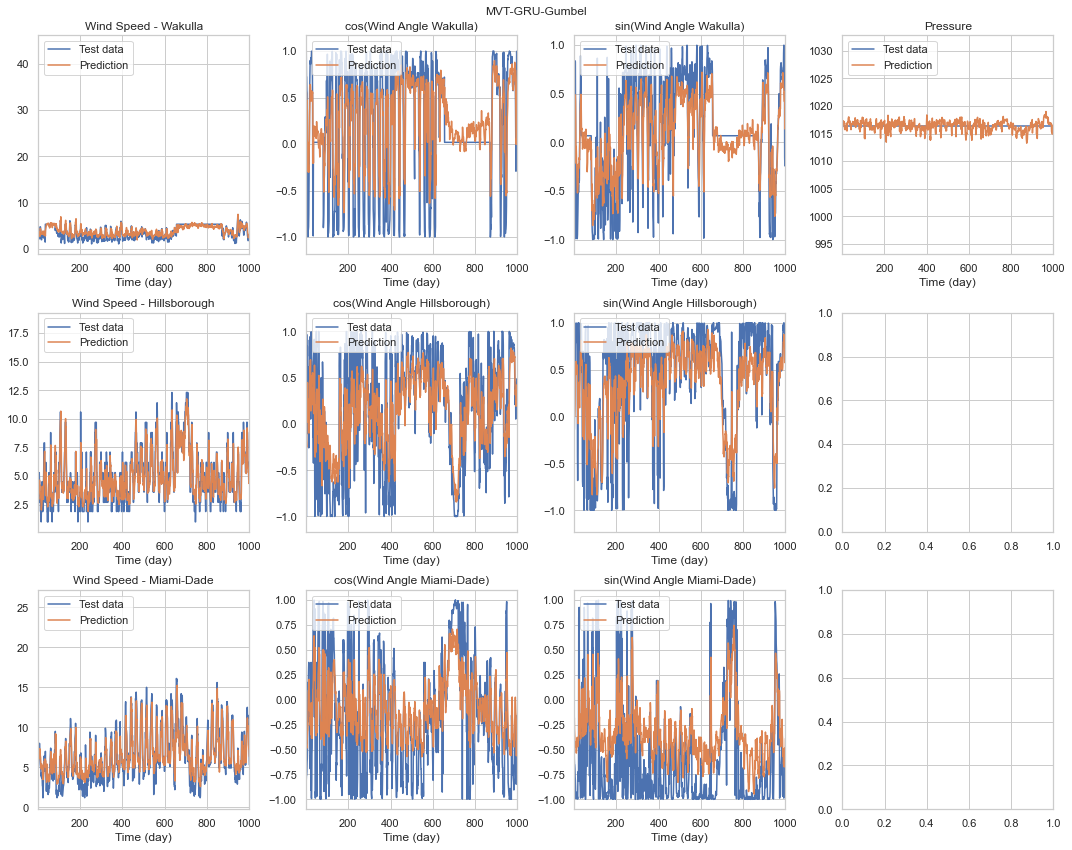

                           Var  MVT-GRU-Gumbel-MAE  MVT-GRU-Gumbel-RMSE
0           Wind_Speed_wakulla            1.108194             0.657168
1  Barometric_Pressure_wakulla            1.266209             0.763850
2         cos_Wind_Dir_wakulla            0.420859             0.290033
3         sin_Wind_Dir_wakulla            0.360168             0.254307
4      Wind_Speed_hillsborough            1.171521             0.623633
5    cos_Wind_Dir_hillsborough            0.372827             0.225668
6    sin_Wind_Dir_hillsborough            0.381674             0.239948
7             Wind_Speed_miami            1.514880             0.936628
8           cos_Wind_Dir_miami            0.445767             0.355257
9           sin_Wind_Dir_miami            0.424974             0.333251


In [182]:
prediction_gumbel_mvt, pred_gumbel_mvt = mvt_forecast(model_gumbel_mvt, X_test)
plot_forecasts_mvt(pred_gumbel_mvt, "MVT-GRU-Gumbel", y_test_2)

res_gumbel = evaluate_prediction(pred_gumbel_mvt, y_test_2, "MVT-GRU-Gumbel")

358/358 [==============================] - 5s 14ms/step


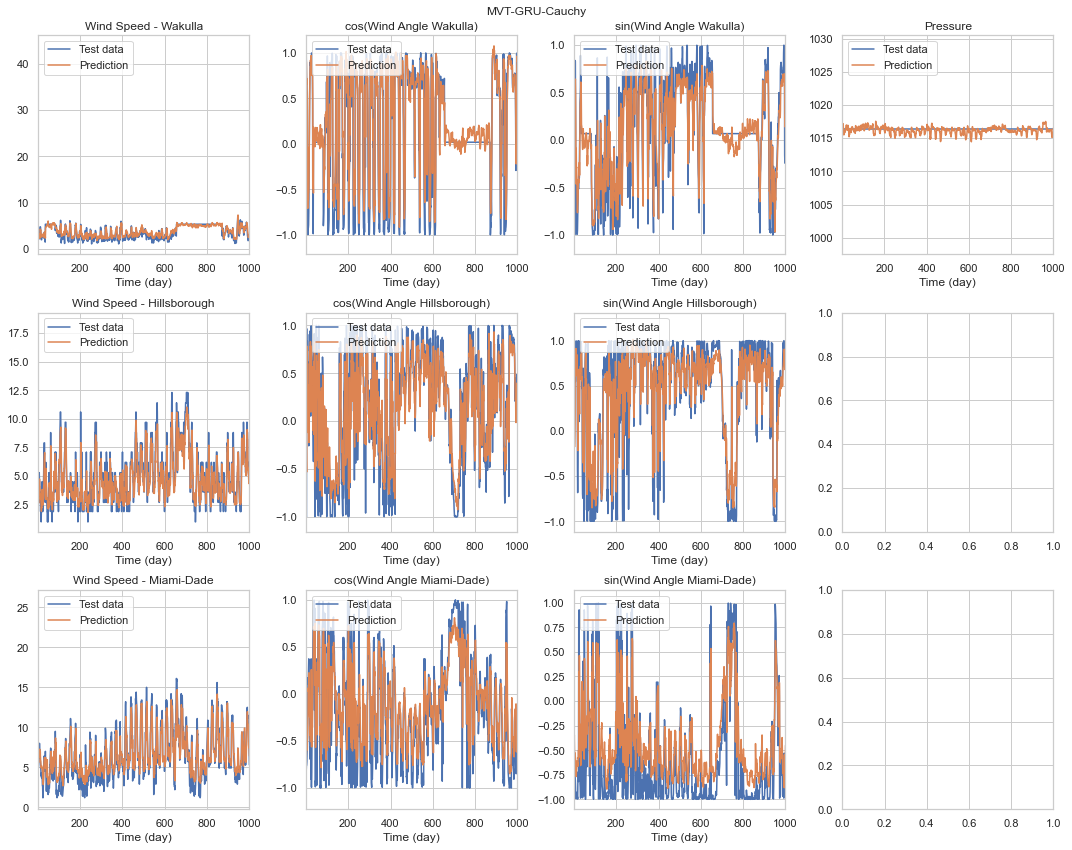

                           Var  MVT-GRU-Cauchy-MAE  MVT-GRU-Cauchy-RMSE
0           Wind_Speed_wakulla            0.993973             0.513081
1  Barometric_Pressure_wakulla            0.881111             0.512543
2         cos_Wind_Dir_wakulla            0.348327             0.150986
3         sin_Wind_Dir_wakulla            0.312563             0.173806
4      Wind_Speed_hillsborough            1.171828             0.598244
5    cos_Wind_Dir_hillsborough            0.340110             0.153300
6    sin_Wind_Dir_hillsborough            0.336229             0.142494
7             Wind_Speed_miami            1.526565             0.925091
8           cos_Wind_Dir_miami            0.359684             0.205567
9           sin_Wind_Dir_miami            0.352775             0.224159


In [183]:
prediction_cauchy_mvt, pred_cauchy_mvt = mvt_forecast(model_cauchy_mvt, X_test)
plot_forecasts_mvt(pred_cauchy_mvt, "MVT-GRU-Cauchy", y_test_2)

res_cauchy = evaluate_prediction(pred_cauchy_mvt, y_test_2, "MVT-GRU-Cauchy")

358/358 [==============================] - 5s 14ms/step


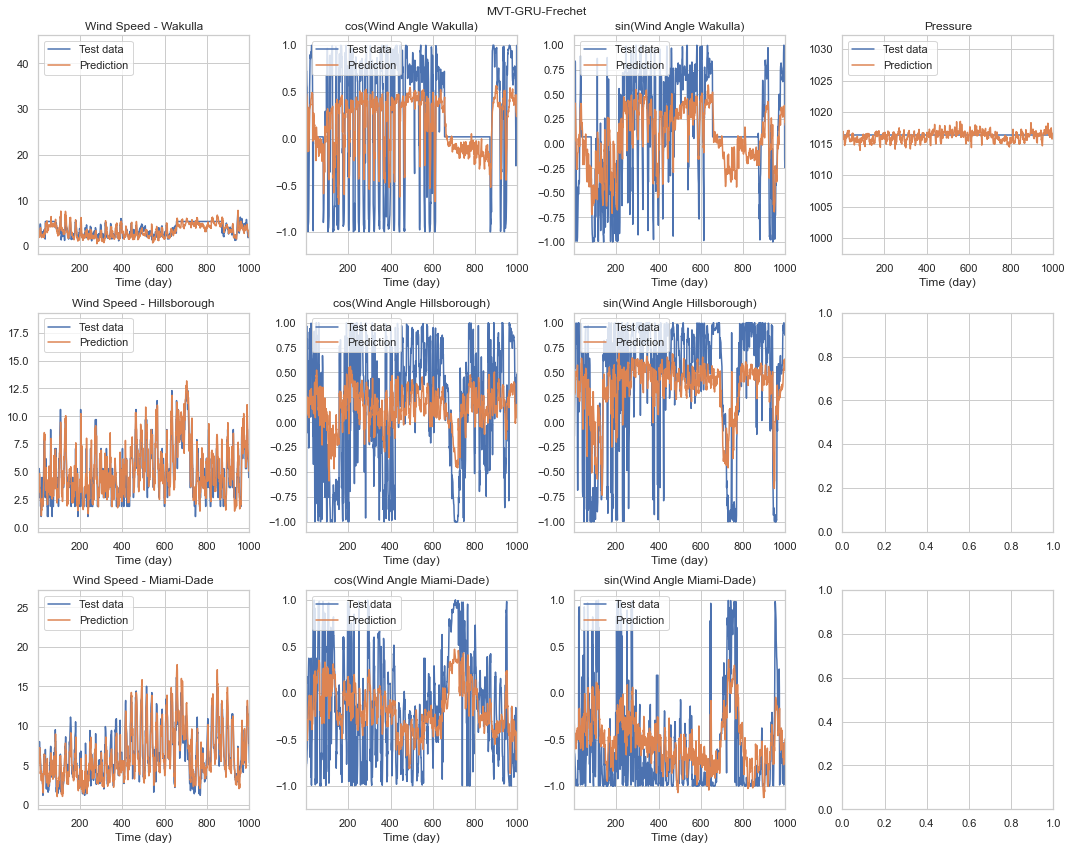

                           Var  MVT-GRU-Frechet-MAE  MVT-GRU-Frechet-RMSE
0           Wind_Speed_wakulla             1.213055              0.673603
1  Barometric_Pressure_wakulla             1.149529              0.673340
2         cos_Wind_Dir_wakulla             0.510643              0.417836
3         sin_Wind_Dir_wakulla             0.441460              0.356270
4      Wind_Speed_hillsborough             1.306211              0.795890
5    cos_Wind_Dir_hillsborough             0.521972              0.447095
6    sin_Wind_Dir_hillsborough             0.465543              0.329728
7             Wind_Speed_miami             1.701207              1.009470
8           cos_Wind_Dir_miami             0.502764              0.414472
9           sin_Wind_Dir_miami             0.469494              0.334288


In [194]:
prediction_frechet_mvt, pred_frechet_mvt = mvt_forecast(model_frechet_mvt, X_test)
mae_frechet = mean_absolute_error(y_test_2, pred_frechet_mvt, multioutput = "raw_values")
for i in range(10):
    pred_frechet_mvt[:,i] = (pred_frechet_mvt[:,i] - mae_frechet[i])
plot_forecasts_mvt(pred_frechet_mvt, "MVT-GRU-Frechet", y_test_2)

res_frechet = evaluate_prediction(pred_frechet_mvt, y_test_2, "MVT-GRU-Frechet")

In [157]:
# prediction_pareto_mvt, pred_pareto_mvt = mvt_forecast(model_pareto_mvt, X_test)
# plot_forecasts_mvt(pred_pareto_mvt, "MVT-GRU-Pareto", y_test_2)

# res_pareto = evaluate_prediction(pred_pareto_mvt, y_test_2, "MVT-GRU-Pareto")

In [195]:
res_full = pd.concat([res_gru, res_gumbel, res_frechet, res_cauchy],
                      join = "outer", axis = 1).iloc[:, [0,1,4,7,10,2,5,8,11]]
res_full.to_csv("forecast_metics.csv")

In [196]:
res_full

,Var,MVT-GRU-Gaussian-MAE,MVT-GRU-Gumbel-MAE,MVT-GRU-Frechet-MAE,MVT-GRU-Cauchy-MAE,MVT-GRU-Gaussian-RMSE,MVT-GRU-Gumbel-RMSE,MVT-GRU-Frechet-RMSE,MVT-GRU-Cauchy-RMSE
0,Wind_Speed_wakulla,1.026280,1.108194,1.213055,0.993973,0.558956,0.657168,0.673603,0.513081
1,Barometric_Pressure_wakulla,0.907212,1.266209,1.149529,0.881111,0.521484,0.763850,0.673340,0.512543
2,cos_Wind_Dir_wakulla,0.360550,0.420859,0.510643,0.348327,0.177675,0.290033,0.417836,0.150986
3,sin_Wind_Dir_wakulla,0.319770,0.360168,0.441460,0.312563,0.185558,0.254307,0.356270,0.173806
4,Wind_Speed_hillsborough,1.149740,1.171521,1.306211,1.171828,0.603507,0.623633,0.795890,0.598244
5,cos_Wind_Dir_hillsborough,0.343502,0.372827,0.521972,0.340110,0.160449,0.225668,0.447095,0.153300
6,sin_Wind_Dir_hillsborough,0.347015,0.381674,0.465543,0.336229,0.167762,0.239948,0.329728,0.142494
7,Wind_Speed_miami,1.501053,1.514880,1.701207,1.526565,0.915966,0.936628,1.009470,0.925091
8,cos_Wind_Dir_miami,0.373304,0.445767,0.502764,0.359684,0.237769,0.355257,0.414472,0.205567
9,sin_Wind_Dir_miami,0.374131,0.424974,0.469494,0.352775,0.267490,0.333251,0.334288,0.224159


In [197]:
print(res_full.iloc[:,[0,1,2,3,4]].to_latex(index = False, float_format = "%.4f"))

\begin{tabular}{lrrrr}
\toprule
                        Var &  MVT-GRU-Gaussian-MAE &  MVT-GRU-Gumbel-MAE &  MVT-GRU-Frechet-MAE &  MVT-GRU-Cauchy-MAE \\
\midrule
         Wind\_Speed\_wakulla &                1.0263 &              1.1082 &               1.2131 &              0.9940 \\
Barometric\_Pressure\_wakulla &                0.9072 &              1.2662 &               1.1495 &              0.8811 \\
       cos\_Wind\_Dir\_wakulla &                0.3606 &              0.4209 &               0.5106 &              0.3483 \\
       sin\_Wind\_Dir\_wakulla &                0.3198 &              0.3602 &               0.4415 &              0.3126 \\
    Wind\_Speed\_hillsborough &                1.1497 &              1.1715 &               1.3062 &              1.1718 \\
  cos\_Wind\_Dir\_hillsborough &                0.3435 &              0.3728 &               0.5220 &              0.3401 \\
  sin\_Wind\_Dir\_hillsborough &                0.3470 &              0.3817 &            

In [198]:
print(res_full.iloc[:,[0,5,6,7,8]].to_latex(index = False, float_format = "%.4f"))

\begin{tabular}{lrrrr}
\toprule
                        Var &  MVT-GRU-Gaussian-RMSE &  MVT-GRU-Gumbel-RMSE &  MVT-GRU-Frechet-RMSE &  MVT-GRU-Cauchy-RMSE \\
\midrule
         Wind\_Speed\_wakulla &                 0.5590 &               0.6572 &                0.6736 &               0.5131 \\
Barometric\_Pressure\_wakulla &                 0.5215 &               0.7638 &                0.6733 &               0.5125 \\
       cos\_Wind\_Dir\_wakulla &                 0.1777 &               0.2900 &                0.4178 &               0.1510 \\
       sin\_Wind\_Dir\_wakulla &                 0.1856 &               0.2543 &                0.3563 &               0.1738 \\
    Wind\_Speed\_hillsborough &                 0.6035 &               0.6236 &                0.7959 &               0.5982 \\
  cos\_Wind\_Dir\_hillsborough &                 0.1604 &               0.2257 &                0.4471 &               0.1533 \\
  sin\_Wind\_Dir\_hillsborough &                 0.1678 &     

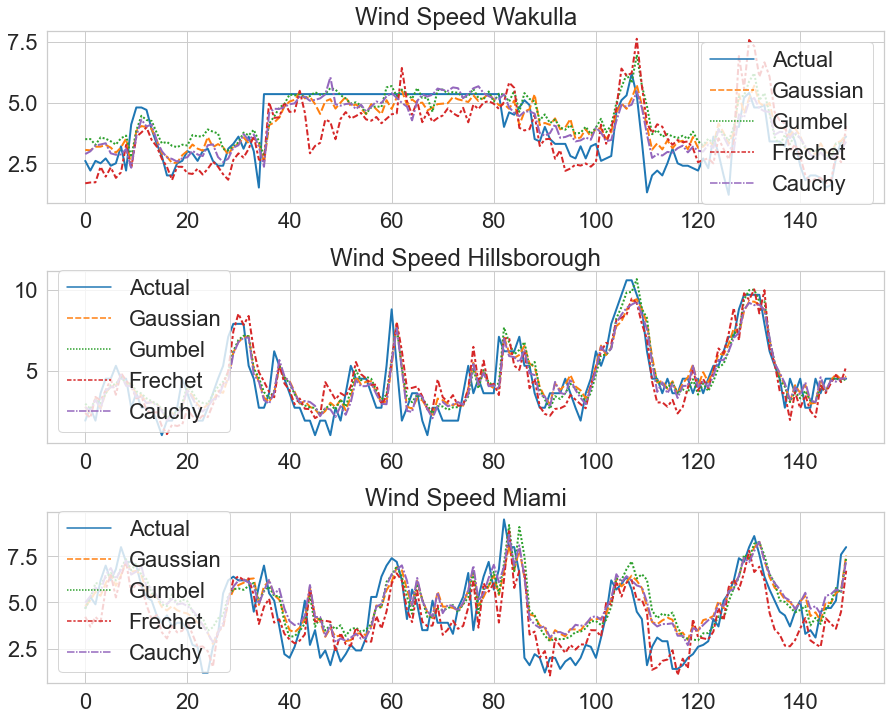

In [221]:
def plot_forecast_all_models(title, var_ind = 0):
    forecast = pd.DataFrame({"Actual": y_test_2[0:150,var_ind],
                        "Gaussian": pred_mvt[0:150,var_ind],
                        "Gumbel": pred_gumbel_mvt[0:150,var_ind],
                        "Frechet": pred_frechet_mvt[0:150,var_ind],
                        "Cauchy": pred_cauchy_mvt[0:150,var_ind]})

    sns.lineplot(data = forecast, palette = "tab10", linewidth = 2).set(title = title)

sns.set_theme(style = "whitegrid", font_scale = 2)
fig = plt.figure()
fig.subplots_adjust(hspace = 0.4, wspace = 0.4)
ax = fig.add_subplot(3,1,1)
plot_forecast_all_models("Wind Speed Wakulla", var_ind = 0)
ax = fig.add_subplot(3,1,2)
plot_forecast_all_models("Wind Speed Hillsborough", var_ind = 4)
ax = fig.add_subplot(3,1,3)
plot_forecast_all_models("Wind Speed Miami", var_ind = 7)

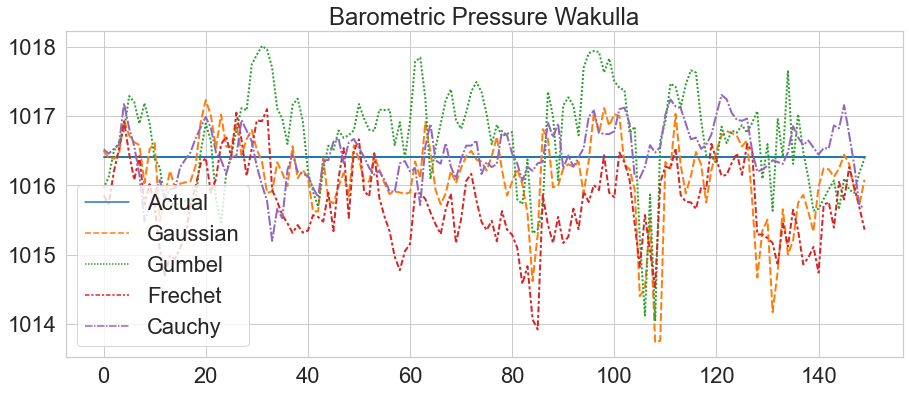

In [224]:
plt.rcParams['figure.figsize'] = [15, 6]

sns.set_theme(style = "whitegrid", font_scale = 2)
# fig = plt.figure()
# fig.subplots_adjust(hspace = 0.4, wspace = 0.4)
# ax = fig.add_subplot(3,1,1)
plot_forecast_all_models("Barometric Pressure Wakulla", var_ind = 1)